# Comparaison entre Tesseract et EasyOCR deux librairies de reconnaissance de texte

In [4]:
import pytesseract
from PIL import Image
import cv2
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import collections
import easyocr
import os
import re

# Définir le chemin vers l'exécutable Tesseract
pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/bin/tesseract'

# Initialiser le lecteur easyOCR avec la langue chinoise simplifiée
reader = easyocr.Reader(['ch_sim'], gpu=True)

## Tesseract

Présentation de l’outil OCR : Tesseract OCR

Tesseract OCR est un outil de reconnaissance optique de caractères (OCR) open-source développé initialement par HP et maintenu actuellement par Google. Il est particulièrement prisé pour sa précision et sa flexibilité dans l’extraction de texte à partir d’images, offrant des performances avancées pour les projets nécessitant une reconnaissance de texte en plusieurs langues.

Fonctionnalités

Tesseract OCR propose plusieurs fonctionnalités adaptées aux tâches de reconnaissance de texte :

1.	Support multilingue étendu : Avec plus de 100 langues supportées, Tesseract peut être utilisé pour des documents multilingues sans configurations complexes.
2.	Modes de segmentation personnalisés : Tesseract propose des configurations de segmentation flexibles (paragraphe, ligne, mot ou caractère), ce qui permet d’optimiser la reconnaissance selon le type de texte.
3.	Extraction de texte en mode dense : Il est capable de lire des documents de texte dense, idéal pour des applications comme la numérisation de livres ou de documents officiels.
4.	OCR basé sur les réseaux neuronaux (LSTM) : Depuis sa version 4.0, Tesseract utilise des réseaux neuronaux de type LSTM (Long Short-Term Memory) pour améliorer la précision dans la reconnaissance de texte manuscrit ou déformé.
5.	Personnalisation par configuration : Tesseract permet des options de configuration poussées, avec des paramètres précis pour adapter le modèle aux caractéristiques spécifiques des images traitées.

Configuration

Pour utiliser Tesseract OCR, il faut d’abord installer le logiciel Tesseract sur la machine (accessible via apt install tesseract-ocr sous Linux, ou un installateur pour Windows/macOS), puis l’appeler depuis des bibliothèques comme pytesseract en Python. La configuration permet de spécifier la langue souhaitée et le mode de segmentation grâce aux paramètres --oem (mode d’OCR, incluant LSTM ou hybride) et --psm (mode de segmentation), rendant Tesseract très modulable.

Avantages pour la tâche

Pour une tâche d’extraction de caractères chinois, Tesseract présente plusieurs atouts :

- Support du chinois simplifié : Tesseract prend en charge le chinois simplifié, permettant d’extraire du texte avec une précision généralement fiable pour cette langue.
- Modes de segmentation adaptés aux caractères isolés : Tesseract offre un mode de segmentation par caractère (via --psm 10), qui peut être utilisé pour isoler les caractères et les traiter un par un, ce qui est optimal pour une tâche de reconnaissance de caractères individuels.
- Options de prétraitement flexibles : Avec Tesseract, il est possible d’ajuster l’extraction de texte en fonction des spécificités de l’image (par exemple, gestion de l’angle, du bruit), ce qui permet d’améliorer la qualité de reconnaissance sur des images de qualité variable.
- Robustesse et fiabilité : Tesseract est bien établi dans le domaine de l’OCR et dispose d’une large communauté de soutien, offrant une documentation riche et des ressources pour améliorer son utilisation.

Inconvénients pour la tâche

Tesseract OCR comporte cependant quelques limites qui peuvent affecter les performances :

- Précision moindre pour les caractères individuels : Bien que Tesseract puisse segmenter des caractères, il est davantage optimisé pour des documents en blocs de texte, ce qui peut affecter la précision pour une tâche nécessitant une détection de caractères isolés.
- Sensible au bruit et à la qualité d’image : Tesseract nécessite des images bien définies pour obtenir de bonnes performances. Des prétraitements tels que la réduction du bruit et la mise au seuil sont souvent indispensables pour garantir la précision des résultats.
- Complexité de configuration pour le multilingue : Bien qu’il supporte de nombreuses langues, Tesseract peut nécessiter des ajustements précis pour passer d’une langue à une autre, notamment pour des documents contenant plusieurs langues.

Justification du choix de l’outil

Le choix de Tesseract pour cette tâche repose sur sa réputation en termes de précision et sa capacité à traiter des caractères complexes grâce à l’OCR LSTM. La prise en charge du chinois simplifié et la possibilité d’isoler les caractères font de Tesseract un outil adapté aux besoins de ce projet, malgré les précautions à prendre en termes de qualité d’image et de segmentation.

Comparé à d’autres outils comme easyOCR, Tesseract offre une personnalisation approfondie des configurations et une précision reconnue pour les projets OCR classiques. De plus, son mode open-source et la richesse de ses options de configuration permettent une grande flexibilité pour des utilisateurs techniques recherchant un contrôle sur les résultats.



In [45]:
def preprocess_image(image_path):
    # Charger l'image en niveaux de gris
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Appliquer un flou pour réduire le bruit
    img = cv2.GaussianBlur(img, (5, 5), 0)
    # Appliquer une binarisation (seuil adaptatif)
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return img

# Chargement du fichier CSV en DataFrame
file_path = 'data/data_120.csv'
data = pd.read_csv(file_path)

# Filtrer uniquement les lignes où 'Directory' est 'Test'
test_data = data[data['Directory'] == 'Test']

# Listes pour stocker les vérités terrain et les prédictions
true_labels = []
predicted_labels = []

# Traitement des images avec une barre de progression
for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Traitement des images", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}"):
    character = row['Character']
    img_path = row['Paths']  # Ajustez ce nom en fonction de l'intitulé exact dans le CSV

    # Prétraiter l'image
    processed_img = preprocess_image(img_path)
    
    # Extraire le texte de l'image avec Tesseract
    custom_config = r'--oem 3 --psm 10'  # Mode de segmentation pour un seul caractère
    text = pytesseract.image_to_string(processed_img, lang='chi_sim', config=custom_config).strip()
    
    # Ajouter les vérités terrain et les prédictions aux listes
    true_labels.append(character)
    predicted_labels.append(text)

# Calcul des métriques globales de précision, rappel, et F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted', zero_division=0)
correct_predictions = sum([1 for true, pred in zip(true_labels, predicted_labels) if true == pred])
error_rate = (1 - (correct_predictions / len(test_data))) * 100

# Afficher les résultats
print("\nÉvaluation des performances:")
print(f"Précision (moyenne pondérée) : {precision * 100:.2f}%")
print(f"Rappel (moyenne pondérée) : {recall * 100:.2f}%")
print(f"F1 Score (moyenne pondérée) : {f1_score * 100:.2f}%")
print(f"Taux d'erreur : {error_rate:.2f}%")

# Afficher le rapport de classification complet
print("\nRapport de Classification :")
print(classification_report(true_labels, predicted_labels, zero_division=0))

# Enregistrer les résultats dans un fichier texte
with open('./tesseract-easyocr_results/report_tesseract_120.txt', 'w') as f:
    f.write("Évaluation des performances:\n")
    f.write(f"Précision (moyenne pondérée) : {precision * 100:.2f}%\n")
    f.write(f"Rappel (moyenne pondérée) : {recall * 100:.2f}%\n")
    f.write(f"F1 Score (moyenne pondérée) : {f1_score * 100:.2f}%\n")
    f.write(f"Taux d'erreur : {error_rate:.2f}%\n\n")
    f.write("Rapport de Classification :\n")
    f.write(classification_report(true_labels, predicted_labels, zero_division=0))

Traitement des images: 100%|██████████| 17138/17138



Évaluation des performances:
Précision (moyenne pondérée) : 53.06%
Rappel (moyenne pondérée) : 7.08%
F1 Score (moyenne pondérée) : 9.87%
Taux d'erreur : 92.92%

Rapport de Classification :
              precision    recall  f1-score   support

                   0.00      0.00      0.00         0
           !       0.00      0.00      0.00         0
           "       0.00      0.00      0.00         0
           #       0.00      0.00      0.00         0
         # 华       0.00      0.00      0.00         0
         # 圣       0.00      0.00      0.00         0
         # 心       0.00      0.00      0.00         0
           $       0.00      0.00      0.00         0
           %       0.00      0.00      0.00         0
         %0、       0.00      0.00      0.00         0
          %o       0.00      0.00      0.00         0
           &       0.00      0.00      0.00         0
          &|       0.00      0.00      0.00         0
           '       0.00      0.00      0.00         0

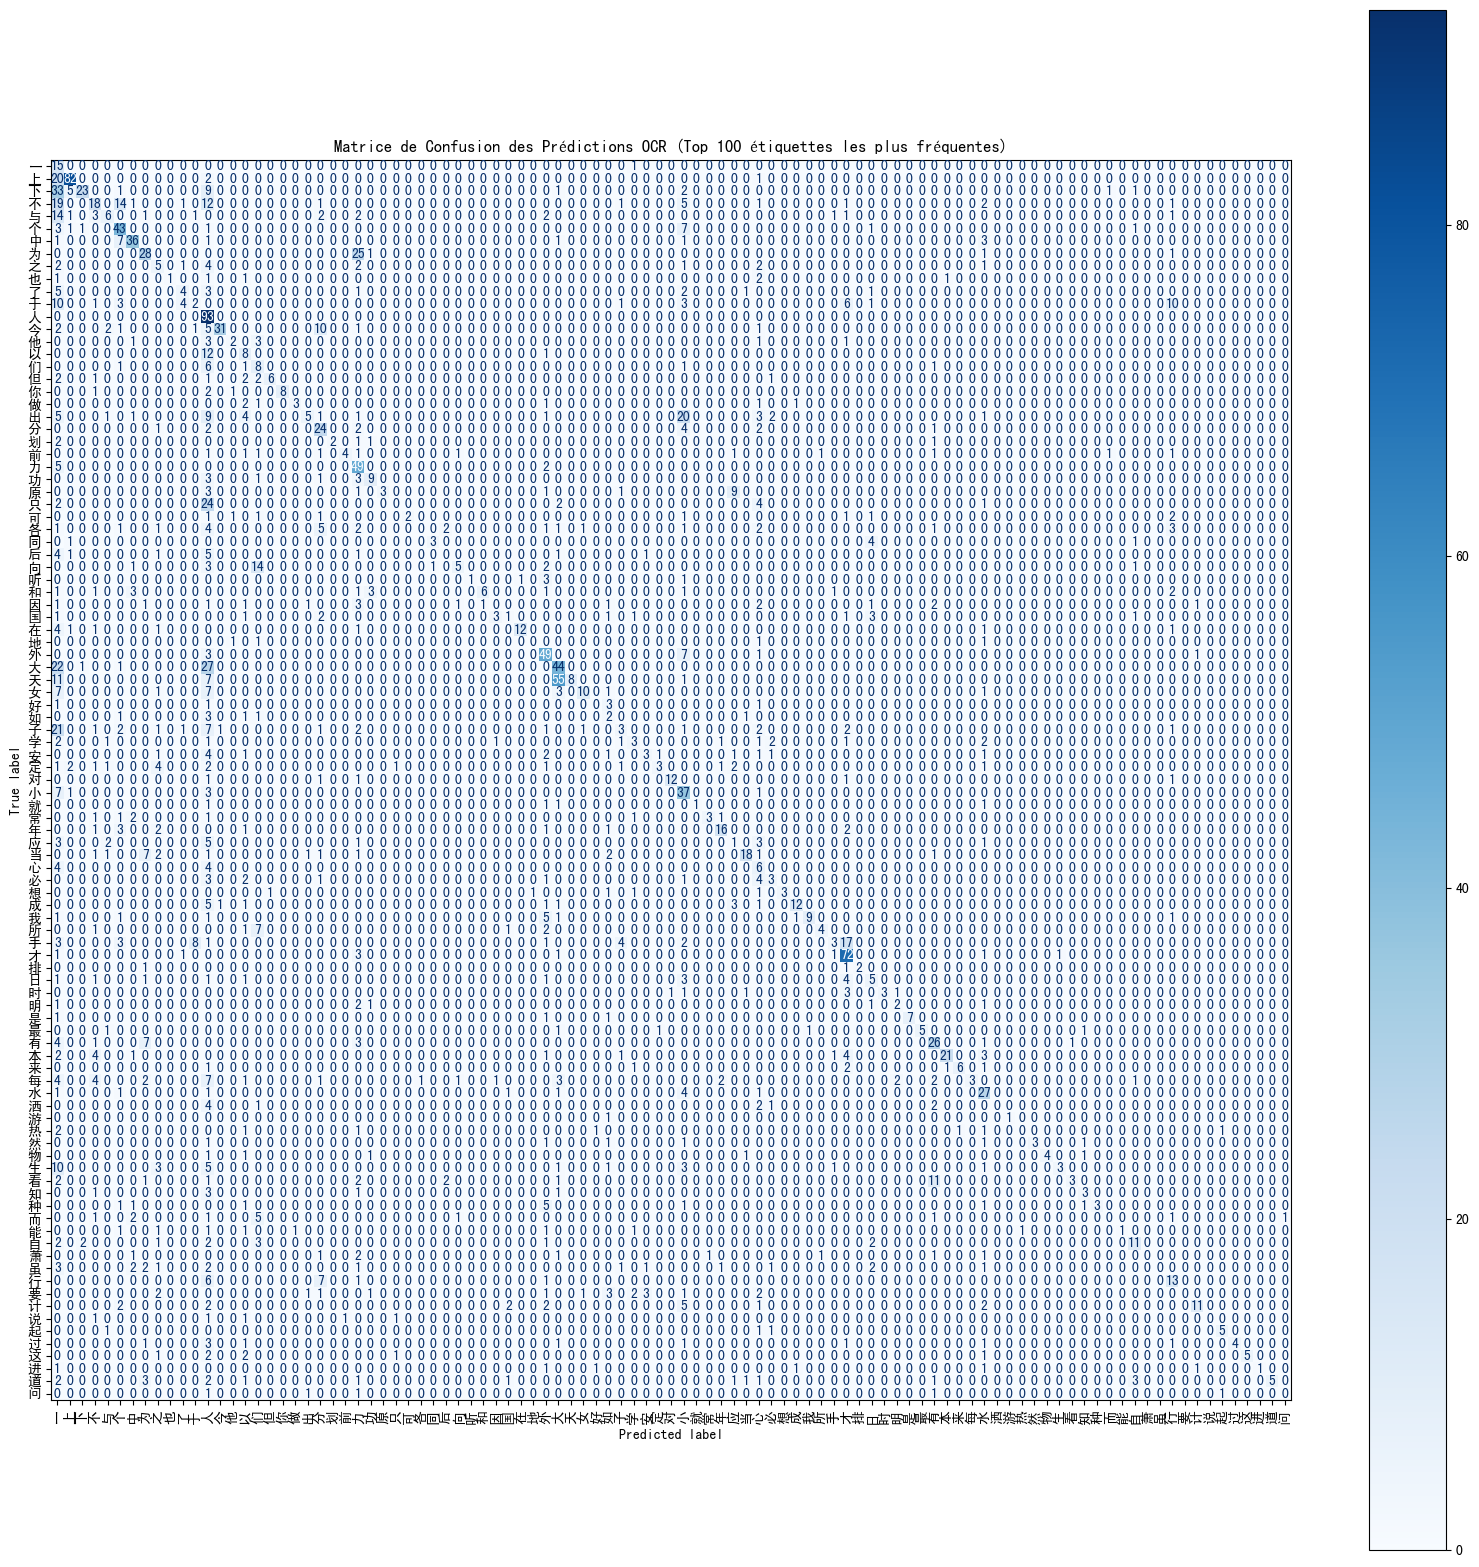

In [ ]:
# Compter la fréquence des étiquettes dans true_labels
label_counts = collections.Counter(true_labels)
# Sélectionner les N étiquettes les plus fréquentes
N = 100  # Ajustez ce nombre selon les besoins
most_common_labels = [label for label, _ in label_counts.most_common(N)]

# Filtrer les paires (true_label, predicted_label) pour inclure uniquement les étiquettes les plus fréquentes
filtered_true_labels = []
filtered_predicted_labels = []
for true_label, predicted_label in zip(true_labels, predicted_labels):
    if true_label in most_common_labels and predicted_label in most_common_labels:
        filtered_true_labels.append(true_label)
        filtered_predicted_labels.append(predicted_label)

# Créer une liste unique des étiquettes filtrées
filtered_labels = np.unique(filtered_true_labels + filtered_predicted_labels)

# Calcul de la matrice de confusion filtrée
conf_matrix = confusion_matrix(filtered_true_labels, filtered_predicted_labels, labels=filtered_labels)
cmd = ConfusionMatrixDisplay(conf_matrix, display_labels=filtered_labels)

# Générer et enregistrer la matrice de confusion en haute résolution
fig, ax = plt.subplots(figsize=(20, 20))
cmd.plot(cmap="Blues", xticks_rotation=90, ax=ax)
plt.title(f"Matrice de Confusion des Prédictions OCR (Top {N} étiquettes les plus fréquentes)")

# Sauvegarder l'image avec une résolution très élevée
plt.savefig("./tesseract-easyocr_results/confusion_matrix_high_res_tesseract_120.png", dpi=600)  # Augmentez dpi si nécessaire
plt.show()

### Guilhem Dataset

In [32]:
# Dossier contenant les images
image_folder = './Char'

# Listes pour stocker les vérités terrain et les prédictions
true_labels_g = []
predicted_labels_g = []

# Traitement des images dans le dossier sans sous-dossiers
for filename in tqdm(os.listdir(image_folder), desc="Traitement des images", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}"):
    img_path = os.path.join(image_folder, filename)
    
    # Vérifie si le fichier est une image JPG et non un sous-dossier
    if os.path.isfile(img_path) and filename.endswith('.jpg'):
        
        # Extraire le label du nom du fichier en enlevant les chiffres
        true_label = re.sub(r'\d+', '', os.path.splitext(filename)[0])
        
        # Prétraiter l'image
        processed_img = preprocess_image(img_path)
        
        # Extraire le texte de l'image avec Tesseract
        custom_config = r'--oem 3 --psm 10'  # Mode de segmentation pour un seul caractère
        text = pytesseract.image_to_string(processed_img, lang='chi_sim', config=custom_config).strip()
        
        # Ajouter les vérités terrain et les prédictions aux listes
        true_labels_g.append(true_label)
        predicted_labels_g.append(text)

# Calcul des métriques globales de précision, rappel, et F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels_g, predicted_labels_g, average='weighted', zero_division=0)
correct_predictions = sum([1 for true, pred in zip(true_labels_g, predicted_labels_g) if true == pred])
error_rate = (1 - (correct_predictions / len(true_labels_g))) * 100

# Afficher les résultats
print("\nÉvaluation des performances:")
print(f"Précision (moyenne pondérée) : {precision * 100:.2f}%")
print(f"Rappel (moyenne pondérée) : {recall * 100:.2f}%")
print(f"F1 Score (moyenne pondérée) : {f1_score * 100:.2f}%")
print(f"Taux d'erreur : {error_rate:.2f}%")

# Afficher le rapport de classification complet
print("\nRapport de Classification :")
print(classification_report(true_labels_g, predicted_labels_g, zero_division=0))

# Enregistrer les résultats dans un fichier texte
with open('./tesseract-easyocr_results/report_tesseract_Guilhem_dataset.txt', 'w') as f:
    f.write("Évaluation des performances:\n")
    f.write(f"Précision (moyenne pondérée) : {precision * 100:.2f}%\n")
    f.write(f"Rappel (moyenne pondérée) : {recall * 100:.2f}%\n")
    f.write(f"F1 Score (moyenne pondérée) : {f1_score * 100:.2f}%\n")
    f.write(f"Taux d'erreur : {error_rate:.2f}%\n\n")
    f.write("Rapport de Classification :\n")
    f.write(classification_report(true_labels_g, predicted_labels_g, zero_division=0))

Traitement des images: 100%|██████████| 65/65


Évaluation des performances:
Précision (moyenne pondérée) : 14.06%
Rappel (moyenne pondérée) : 7.81%
F1 Score (moyenne pondérée) : 9.27%
Taux d'erreur : 92.19%

Rapport de Classification :
              precision    recall  f1-score   support

                   0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
         2 有       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
         5 纤       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
         ; 义       0.00      0.00      0.00         0
         ; 於       0.00      0.00      0.00         0
           C       0.00      0.00      0.00         0
           G       0.00      0.00      0.00         1
         J 多       0.00      0.00      0.00         0
          PT       0.00      0.00      0.00         0
           Z       0.00      0.00      0.00         0
           h       0.00      0.00      0.00         0

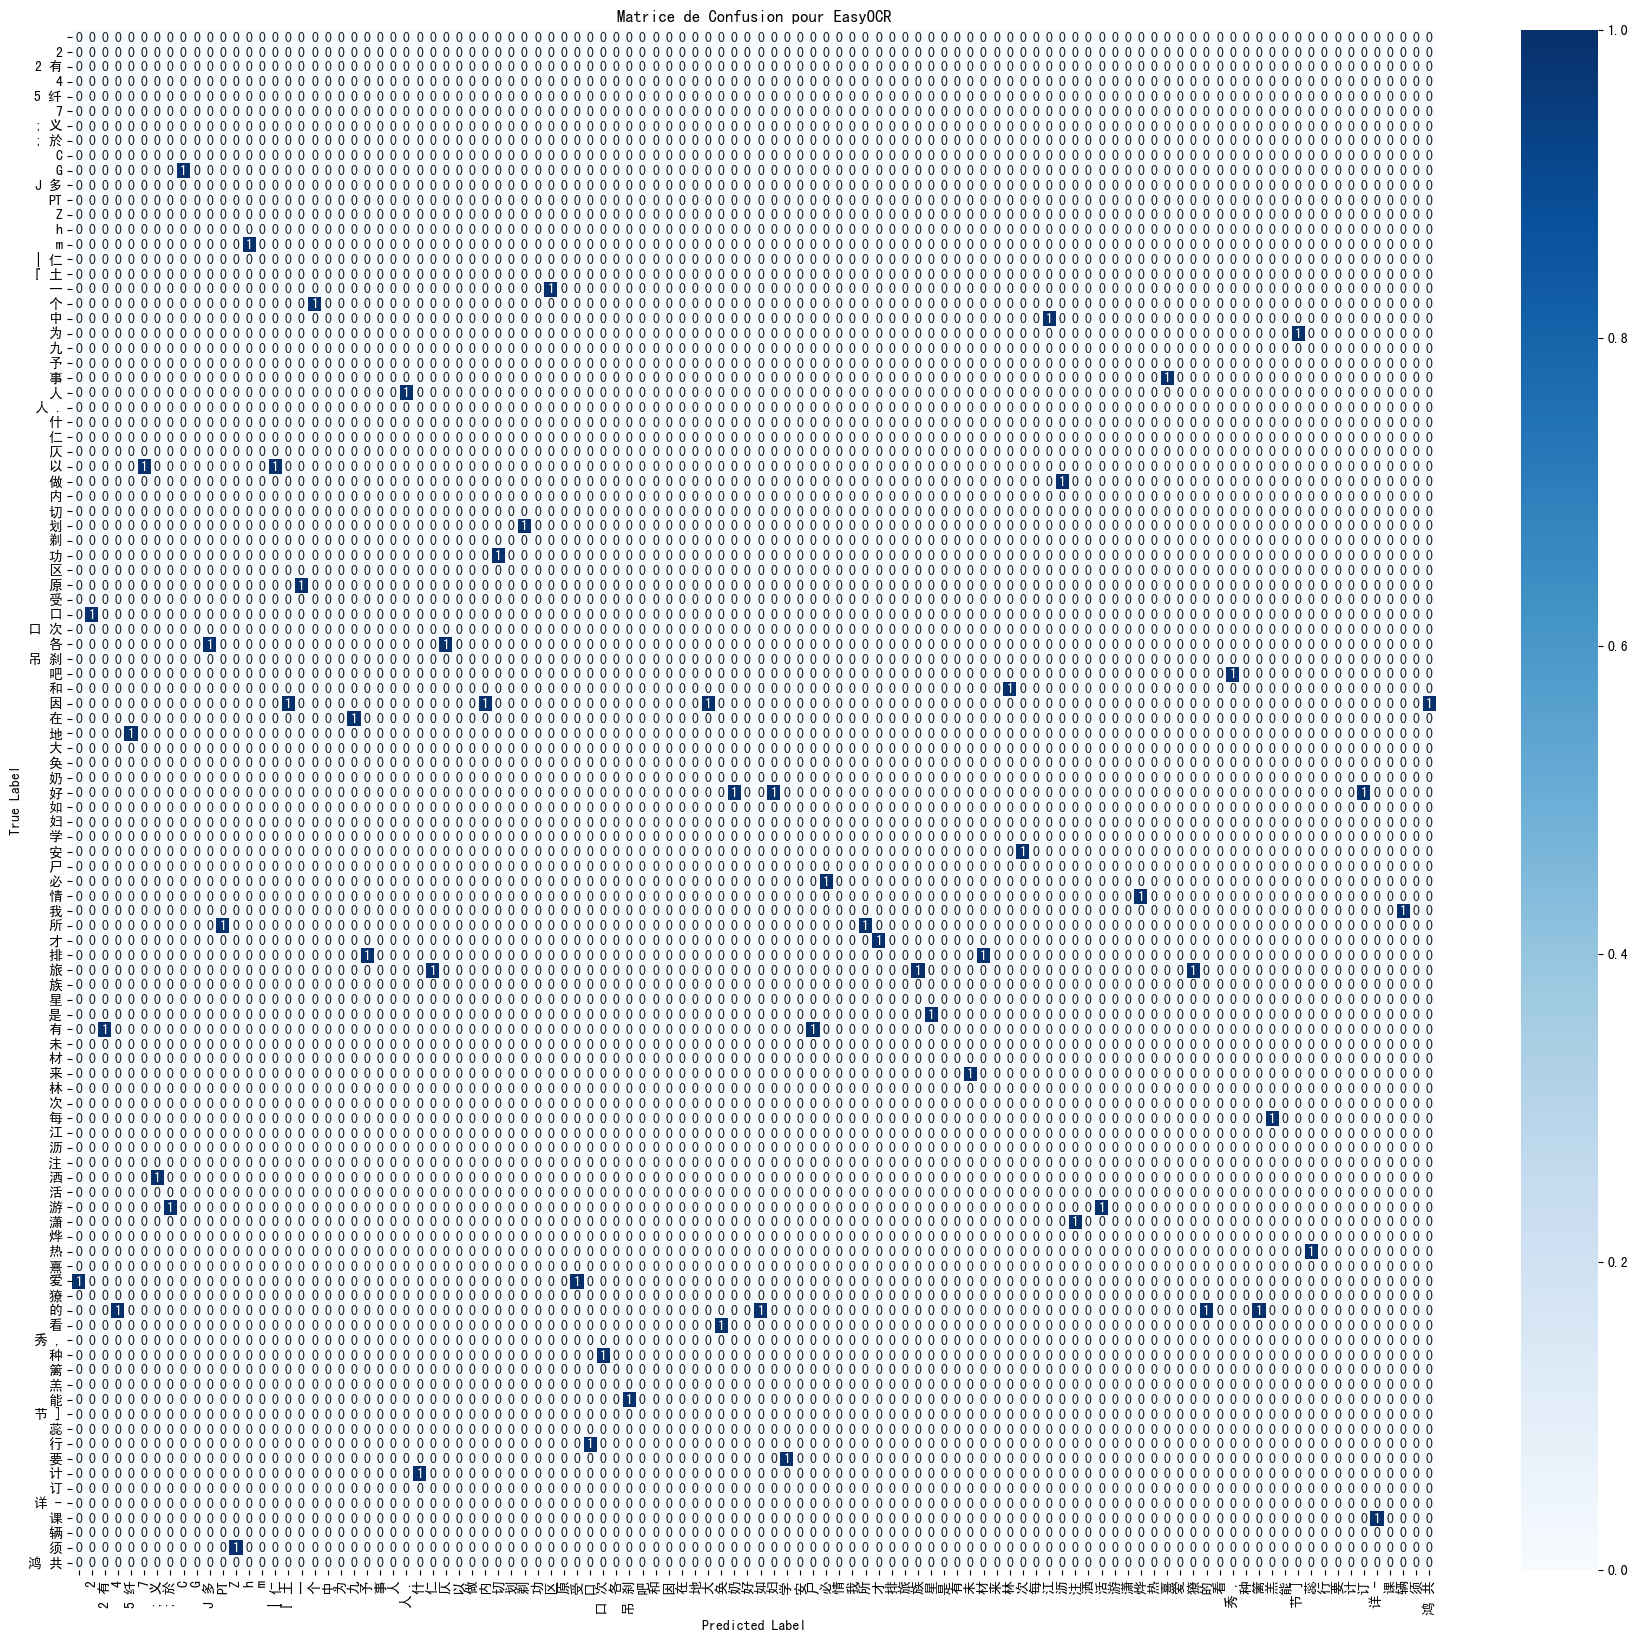

<Figure size 640x480 with 0 Axes>

In [41]:
# Création de la matrice de confusion
all_labels = sorted(list(set(true_labels_g) | set(predicted_labels_g)))  # Assure que tous les labels sont inclus
conf_matrix = confusion_matrix(true_labels_g, predicted_labels_g, labels=all_labels)

# Affichage de la matrice de confusion
plt.figure(figsize=(22, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=all_labels, yticklabels=all_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matrice de Confusion pour EasyOCR')
plt.show()

# Sauvegarder la matrice de confusion dans un fichier image
plt.savefig('./tesseract-easyocr_results/confusion_matrix_tesseract_guilhem_dataset.png')

_______________________________________________________________________________________________________________

## EasyOCR

Présentation de l’outil OCR : EasyOCR

EasyOCR est une bibliothèque de reconnaissance optique de caractères (OCR) open-source, développée par Jaided AI, qui se distingue par sa facilité d’utilisation et ses performances. Cet outil est particulièrement populaire pour l’extraction de texte multilingue et prend en charge plus de 80 langues, incluant des langues à caractères complexes comme le chinois, le japonais et le coréen. Cette capacité multilingue en fait un choix solide pour des applications nécessitant de traiter des documents dans plusieurs langues.

Fonctionnalités

EasyOCR offre plusieurs fonctionnalités qui facilitent le traitement et l’extraction de texte :

1. Reconnaissance de texte multilingue : Support étendu pour de nombreuses langues, idéal pour des projets nécessitant une flexibilité linguistique.
2.	Utilisation de modèles de deep learning : EasyOCR repose sur des modèles de réseaux neuronaux profonds entraînés pour la détection et la reconnaissance de texte, garantissant une précision élevée.
3.	Configuration simple : Grâce à une interface simple, il suffit de quelques lignes de code pour extraire du texte d’une image.
4.	Compatibilité GPU : Pour les environnements nécessitant une extraction de texte rapide sur un grand nombre d’images, EasyOCR peut utiliser un GPU pour accélérer les performances.
5.	Option d’extraction de paragraphes ou caractères individuels : Cela permet une flexibilité selon le type de tâche, que ce soit pour des blocs de texte ou des caractères isolés.

Configuration

Pour utiliser EasyOCR, il suffit d’installer la bibliothèque via pip install easyocr et de spécifier la ou les langues souhaitées lors de l’initialisation. Pour extraire le texte d’une image, une méthode simple, readtext, permet de lancer l’OCR en un appel de fonction. Le GPU peut être activé en ajoutant une option (gpu=True), ce qui est particulièrement utile pour le traitement en batch ou les images volumineuses.

Avantages pour la tâche

EasyOCR est bien adapté à notre tâche d’extraction de caractères chinois pour plusieurs raisons :

- Support des langues asiatiques : Contrairement à de nombreux autres outils OCR qui ne gèrent pas bien les caractères asiatiques, EasyOCR offre un modèle spécialisé pour les caractères chinois simplifiés, garantissant des résultats plus précis.
- Flexibilité pour l’extraction de caractères individuels : En mode segmenté, EasyOCR est capable de détecter les caractères de manière isolée, ce qui est crucial dans une tâche de reconnaissance de caractères uniques.
- Simplicité et rapidité : L’interface intuitive d’EasyOCR permet une configuration rapide, sans besoin de prétraitement complexe. Son exécution est relativement rapide et peut être optimisée avec le GPU si nécessaire.

Inconvénients pour la tâche

Malgré ses nombreux avantages, EasyOCR présente quelques limites pour cette tâche :

- Précision variable sur les caractères individuels : Le modèle OCR est plus précis pour des paragraphes que pour des caractères individuels, ce qui peut générer des erreurs de prédiction dans des tâches très spécifiques.
- Nécessité d’un GPU pour les grandes séries : Pour une performance optimale, notamment avec des images de haute qualité, l’utilisation d’un GPU est conseillée, ce qui peut limiter son utilisation sur des machines standard.
- Dépendance aux conditions d’image : EasyOCR peut être sensible au bruit visuel ou aux images de mauvaise qualité, nécessitant des étapes de prétraitement supplémentaires pour garantir une précision optimale.

Justification du choix de l’outil

EasyOCR a été choisi pour cette tâche en raison de sa prise en charge de la langue chinoise simplifiée, essentielle pour notre projet. La configuration rapide et les bonnes performances de reconnaissance de caractères multilingues le rendent idéal pour les applications nécessitant une extraction de texte dans plusieurs langues. De plus, sa flexibilité dans la configuration et sa simplicité d’utilisation font d’EasyOCR une option accessible et efficace pour des tâches variées, même pour un utilisateur n’ayant pas d’expertise poussée en machine learning.

Enfin, bien que des alternatives telles que pytesseract existent, EasyOCR présente des avantages pour les caractères asiatiques et permet de gagner en précision et en simplicité, offrant ainsi un équilibre entre accessibilité et performance.



In [20]:
def preprocess_image(image_path):
    """
    Fonction pour prétraiter l'image : conversion en niveaux de gris,
    application d'un flou pour réduire le bruit, et binarisation.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return img

# Charger le fichier CSV en DataFrame
file_path = 'data/data_120.csv'
data = pd.read_csv(file_path)

# Filtrer uniquement les lignes où 'Directory' est 'Test'
test_data = data[data['Directory'] == 'Test']

# Listes pour stocker les vérités terrain et les prédictions
true_labels_easy = []
predicted_labels_easy = []

# Traitement des images avec une barre de progression
for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Traitement des images", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}"):
    character = row['Character']
    img_path = row['Paths']  # Vérifier que le nom correspond bien à la colonne du chemin dans le CSV

    # Prétraiter l'image
    processed_img = preprocess_image(img_path)

    # Utiliser easyOCR pour extraire le texte
    result = reader.readtext(processed_img, detail=0, paragraph=False)
    text = result[0] if result else ""  # Prendre le premier caractère extrait ou une chaîne vide

    # Ajouter le caractère attendu et la prédiction aux listes
    true_labels_easy.append(character)
    predicted_labels_easy.append(text)

# Calcul des métriques
accuracy = accuracy_score(true_labels_easy, predicted_labels_easy) * 100
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels_easy, predicted_labels_easy, average='weighted', zero_division=0)
error_rate = (1 - (accuracy / 100)) * 100

# Afficher les résultats globaux
print("\nÉvaluation des performances :")
print(f"Précision globale (accuracy) : {accuracy:.2f}%")
print(f"Précision (moyenne pondérée) : {precision * 100:.2f}%")
print(f"Rappel (moyenne pondérée) : {recall * 100:.2f}%")
print(f"F1 Score (moyenne pondérée) : {f1_score * 100:.2f}%")

# Afficher le rapport de classification détaillé
print("\nRapport de Classification :")
print(classification_report(true_labels_easy, predicted_labels_easy, zero_division=0))

# Enregistrer les résultats dans un fichier texte
with open('./tesseract-easyocr_results/report_easyocr_120.txt', 'w') as f:
    f.write("Évaluation des performances:\n")
    f.write(f"Précision globale (accuracy) : {accuracy:.2f}%\n")
    f.write(f"Précision (moyenne pondérée) : {precision * 100:.2f}%\n")
    f.write(f"Rappel (moyenne pondérée) : {recall * 100:.2f}%\n")
    f.write(f"F1 Score (moyenne pondérée) : {f1_score * 100:.2f}%\n")
    f.write(f"Taux d'erreur : {error_rate:.2f}%\n\n")
    f.write("Rapport de Classification :\n")
    f.write(classification_report(true_labels_easy, predicted_labels_easy, zero_division=0))

Traitement des images: 100%|██████████| 17138/17138



Évaluation des performances :
Précision globale (accuracy) : 14.23%
Précision (moyenne pondérée) : 86.07%
Rappel (moyenne pondérée) : 14.23%
F1 Score (moyenne pondérée) : 23.18%

Rapport de Classification :
              precision    recall  f1-score   support

                   0.00      0.00      0.00         0
                   0.00      0.00      0.00         0
           _       0.00      0.00      0.00         0
           「       0.00      0.00      0.00         0
           !       0.00      0.00      0.00         0
          !,       0.00      0.00      0.00         0
          !7       0.00      0.00      0.00         0
          !廿       0.00      0.00      0.00         0
           "       0.00      0.00      0.00         0
           #       0.00      0.00      0.00         0
          #        0.00      0.00      0.00         0
         # _       0.00      0.00      0.00         0
          #0       0.00      0.00      0.00         0
          #_       0.00      0.00  

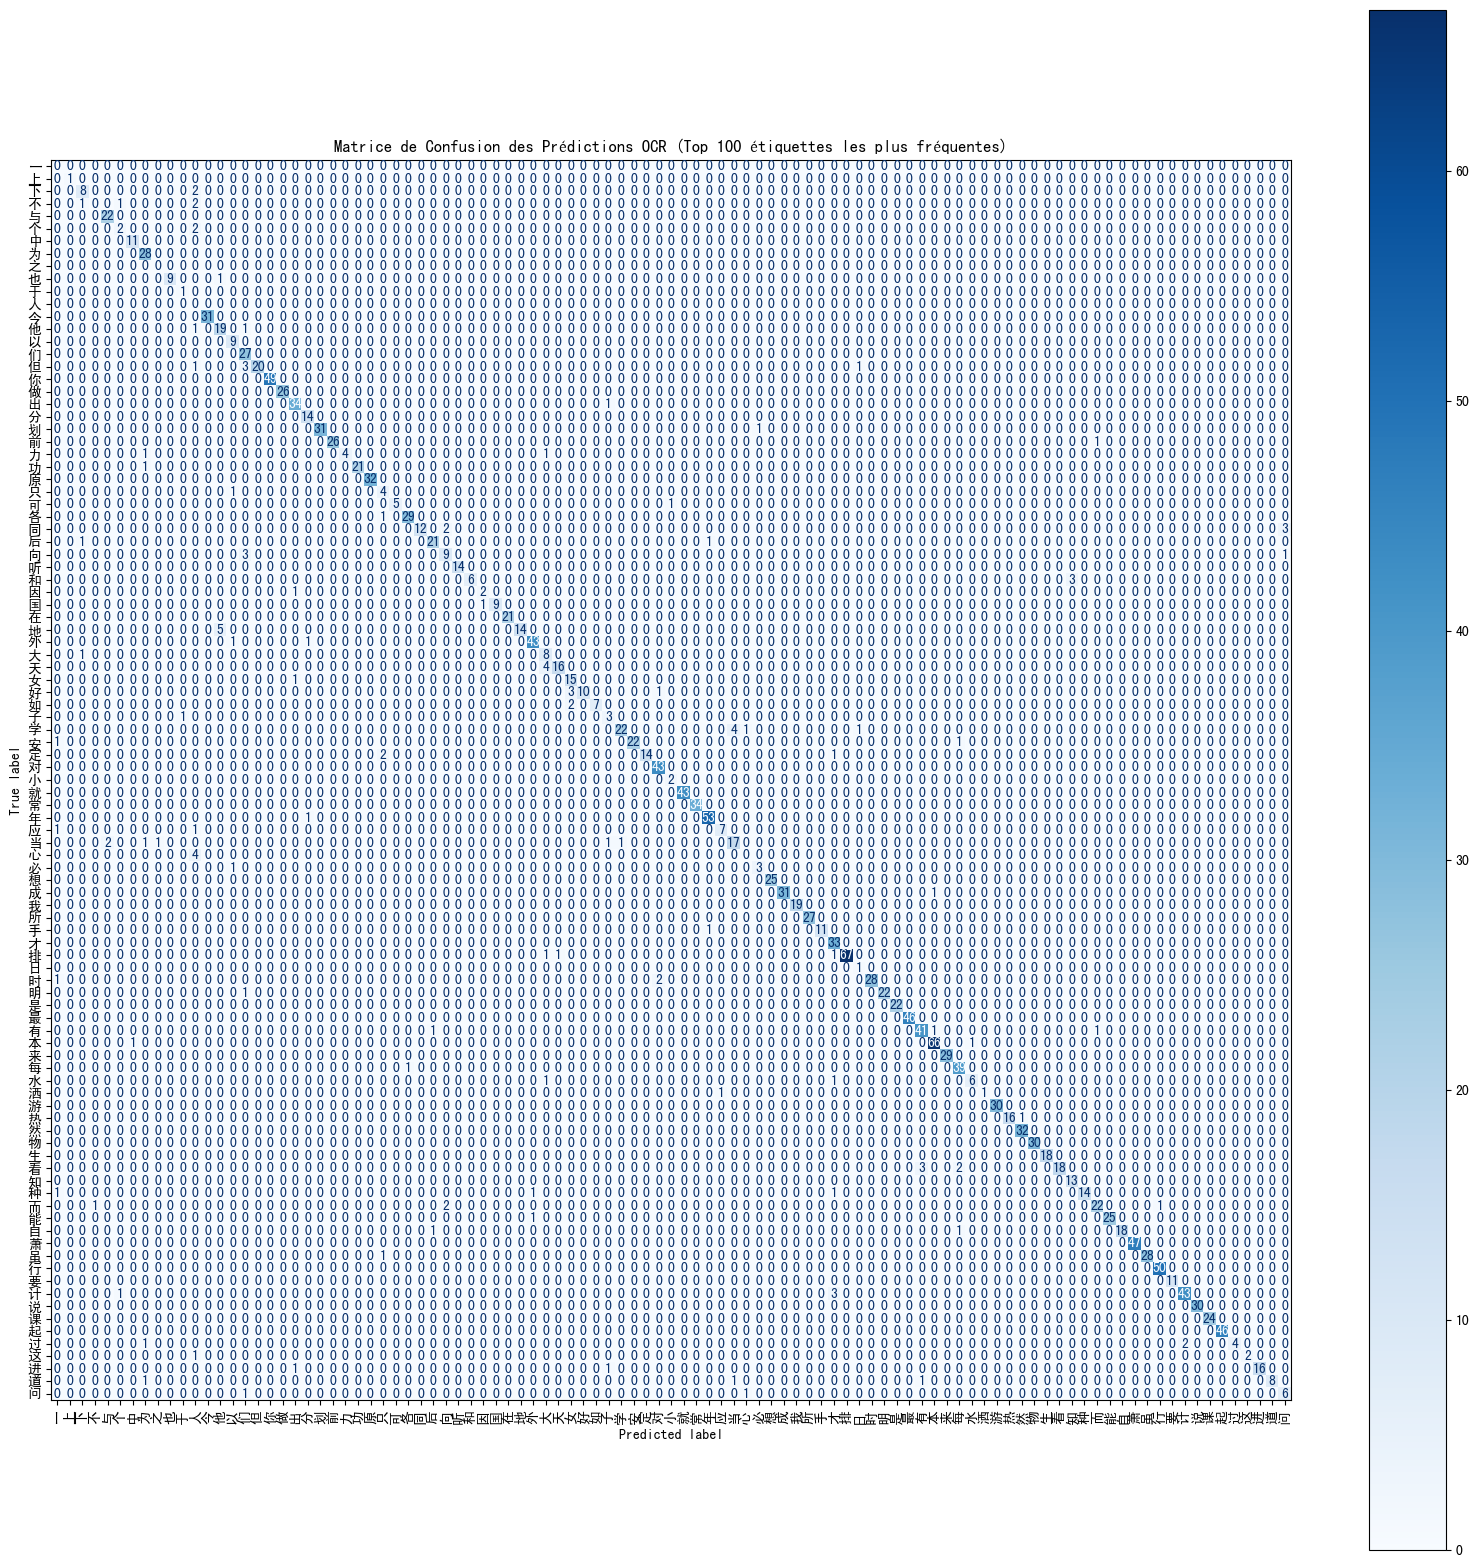

In [ ]:
# Compter la fréquence des étiquettes dans true_labels
label_counts_easy = collections.Counter(true_labels_easy)
# Sélectionner les N étiquettes les plus fréquentes
N = 100  # Ajustez ce nombre selon les besoins
most_common_labels_easy = [label for label, _ in label_counts_easy.most_common(N)]

# Filtrer les paires (true_label, predicted_label) pour inclure uniquement les étiquettes les plus fréquentes
filtered_true_labels_easy = []
filtered_predicted_labels_easy = []
for true_label_easy, predicted_label_easy in zip(true_labels_easy, predicted_labels_easy):
    if true_label_easy in most_common_labels_easy and predicted_label_easy in most_common_labels_easy:
        filtered_true_labels_easy.append(true_label_easy)
        filtered_predicted_labels_easy.append(predicted_label_easy)

# Créer une liste unique des étiquettes filtrées
filtered_labels_easy = np.unique(filtered_true_labels_easy + filtered_predicted_labels_easy)

# Calcul de la matrice de confusion filtrée
conf_matrix = confusion_matrix(filtered_true_labels_easy, filtered_predicted_labels_easy, labels=filtered_labels_easy)
cmd = ConfusionMatrixDisplay(conf_matrix, display_labels=filtered_labels_easy)

# Générer et enregistrer la matrice de confusion en haute résolution
fig, ax = plt.subplots(figsize=(20, 20))
cmd.plot(cmap="Blues", xticks_rotation=90, ax=ax)
plt.title(f"Matrice de Confusion des Prédictions OCR (Top {N} étiquettes les plus fréquentes)")

# Sauvegarder l'image avec une résolution très élevée
plt.savefig("./tesseract-easyocr_results/confusion_matrix_high_res_easyocr_120.png", dpi=600)  # Augmentez dpi si nécessaire
plt.show()

In [15]:
# Dossier contenant les images
image_folder = './Char'

# Listes pour stocker les vérités terrain et les prédictions
true_labels_easy_g = []
predicted_labels_easy_g = []

# Traitement des images dans le dossier sans sous-dossiers
for filename in tqdm(os.listdir(image_folder), desc="Traitement des images", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}"):
    img_path = os.path.join(image_folder, filename)
    # Vérifie si le fichier est une image JPG et non un sous-dossier
    if os.path.isfile(img_path) and filename.endswith('.jpg'):
        
        # Extraire le label du nom du fichier en enlevant les chiffres
        true_label = re.sub(r'\d+', '', os.path.splitext(filename)[0])
        
        # Prétraiter l'image
        processed_img = preprocess_image(img_path)

        # Utiliser easyOCR pour extraire le texte
        result = reader.readtext(processed_img, detail=0, paragraph=False)
        text = result[0] if result else ""  # Prendre le premier caractère extrait ou une chaîne vide

    # Ajouter le caractère attendu et la prédiction aux listes
    true_labels_easy_g.append(true_label)
    predicted_labels_easy_g.append(text)

# Calcul des métriques
accuracy = accuracy_score(true_labels_easy_g, predicted_labels_easy_g) * 100
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels_easy_g, predicted_labels_easy_g, average='weighted', zero_division=0)
error_rate = (1 - (accuracy / 100)) * 100

# Afficher les résultats globaux
print("\nÉvaluation des performances :")
print(f"Précision globale (accuracy) : {accuracy:.2f}%")
print(f"Précision (moyenne pondérée) : {precision * 100:.2f}%")
print(f"Rappel (moyenne pondérée) : {recall * 100:.2f}%")
print(f"F1 Score (moyenne pondérée) : {f1_score * 100:.2f}%")

# Afficher le rapport de classification détaillé
print("\nRapport de Classification :")
print(classification_report(true_labels_easy_g, predicted_labels_easy_g, zero_division=0))

# Enregistrer les résultats dans un fichier texte
with open('./tesseract-easyocr_results/report_easyocr_Guilhem_dataset.txt', 'w') as f:
    f.write("Évaluation des performances:\n")
    f.write(f"Précision globale (accuracy) : {accuracy:.2f}%\n")
    f.write(f"Précision (moyenne pondérée) : {precision * 100:.2f}%\n")
    f.write(f"Rappel (moyenne pondérée) : {recall * 100:.2f}%\n")
    f.write(f"F1 Score (moyenne pondérée) : {f1_score * 100:.2f}%\n")
    f.write(f"Taux d'erreur : {error_rate:.2f}%\n\n")
    f.write("Rapport de Classification :\n")
    f.write(classification_report(true_labels_easy_g, predicted_labels_easy_g, zero_division=0))
        

Traitement des images: 100%|██████████| 65/65


Évaluation des performances :
Précision globale (accuracy) : 24.62%
Précision (moyenne pondérée) : 32.31%
Rappel (moyenne pondérée) : 24.62%
F1 Score (moyenne pondérée) : 27.03%

Rapport de Classification :
              precision    recall  f1-score   support

                   0.00      0.00      0.00         0
           #       0.00      0.00      0.00         0
          #二       0.00      0.00      0.00         0
           $       0.00      0.00      0.00         0
           G       0.00      0.00      0.00         1
           m       0.00      0.00      0.00         1
           ~       0.00      0.00      0.00         0
           一       0.00      0.00      0.00         1
           严       0.00      0.00      0.00         0
           个       0.00      0.00      0.00         1
           中       0.00      0.00      0.00         1
           为       1.00      1.00      1.00         1
          乍|       0.00      0.00      0.00         0
           习       0.00      0.00  

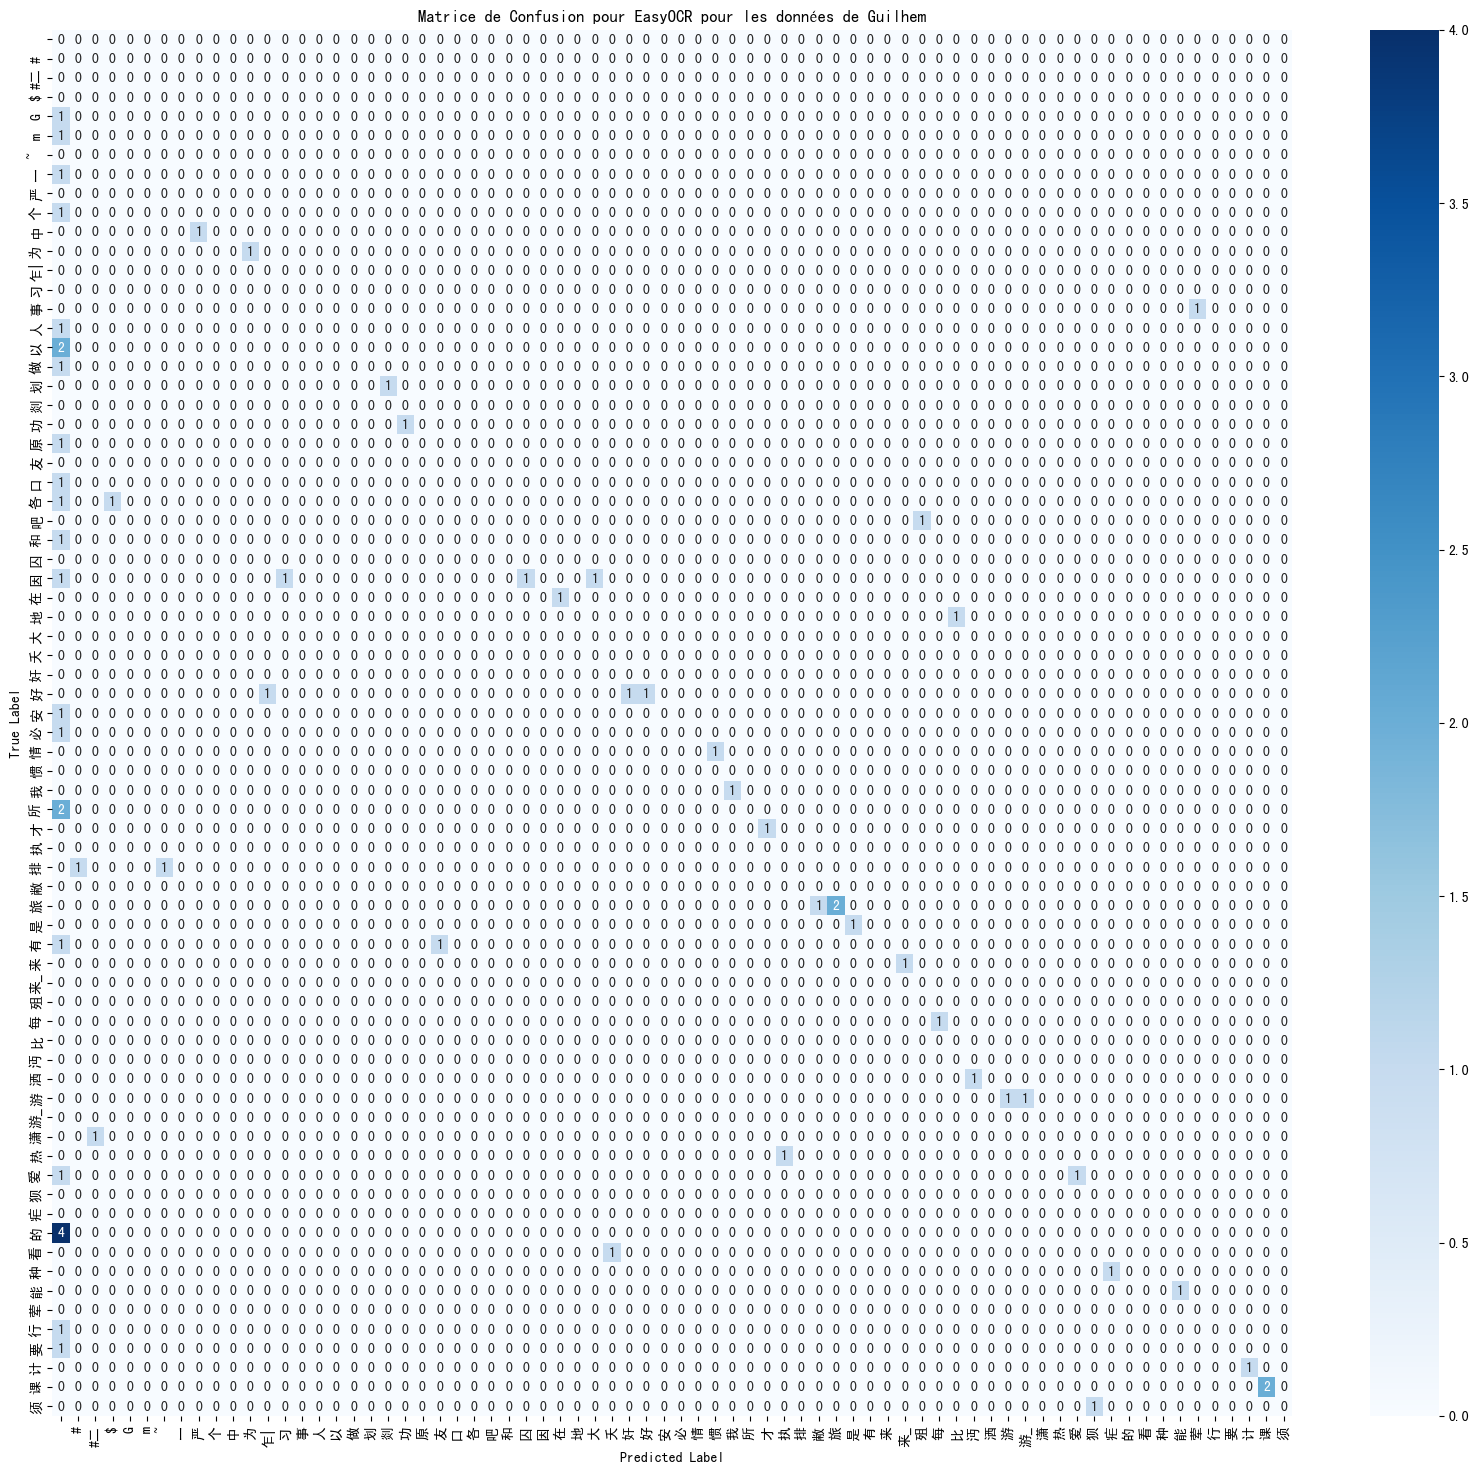

<Figure size 640x480 with 0 Axes>

In [44]:
import seaborn as sns

all_labels = sorted(list(set(true_labels_easy_g) | set(predicted_labels_easy_g)))

# Création de la matrice de confusion
conf_matrix = confusion_matrix(true_labels_easy_g, predicted_labels_easy_g, labels=all_labels)
plt.figure(figsize=(20, 18))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=all_labels, yticklabels=all_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matrice de Confusion pour EasyOCR pour les données de Guilhem')
plt.show()

# Sauvegarder la matrice de confusion dans un fichier
plt.savefig('./tesseract-easyocr_results/confusion_matrix_easyocr_guilhem_dataset.png')